## Classification Problem:
The first step in any classification problem is to look at the dataset you are working with. This will give you some details about the format of images and labels, as well as some insight into how you might approach defining a network to recognize patterns in such an image set.

In [1]:
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

torch.utils.data.Dataset is an abstract class representing a dataset. The FashionMNIST class is an extension of this Dataset class and it allows us to 1. load batches of image/label data, and 2. uniformly apply transformations to our data, such as turning all our images into Tensor's for training a neural network. Tensors are similar to numpy arrays, but can also be used on a GPU to accelerate computing.

In [2]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


we'll use torch.utils.data.DataLoader , which is an iterator that allows us to batch and shuffle the data.
In the next cell, we shuffle the data and load in image/label data in batches of size 20.

In [3]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

This cell iterates over the training dataset, loading a random batch of image/label data, using dataiter.next(). It then plots the batch of images and labels in a 2 x batch_size/2 grid. Each image in this dataset is a 28x28 pixel, normalized, grayscale image.

Normalization ensures that, as we go through a feedforward and then backpropagation step in training our CNN, that each image feature will fall within a similar range of values and not overly activate any particular layer in our network. During the feedfoward step, a network takes in an input image and multiplies each input pixel by some convolutional filter weights (and adds biases!), then it applies some activation and pooling functions. Without normalization, it's much more likely that the calculated gradients in the backpropagaton step will be quite large and cause our loss to increase instead of converge.


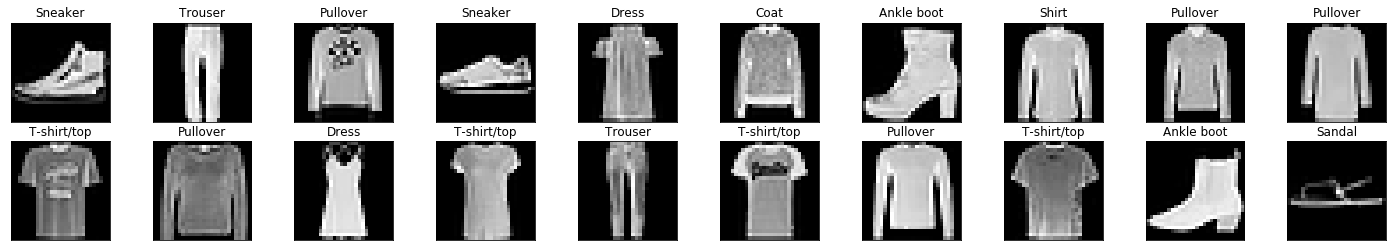

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

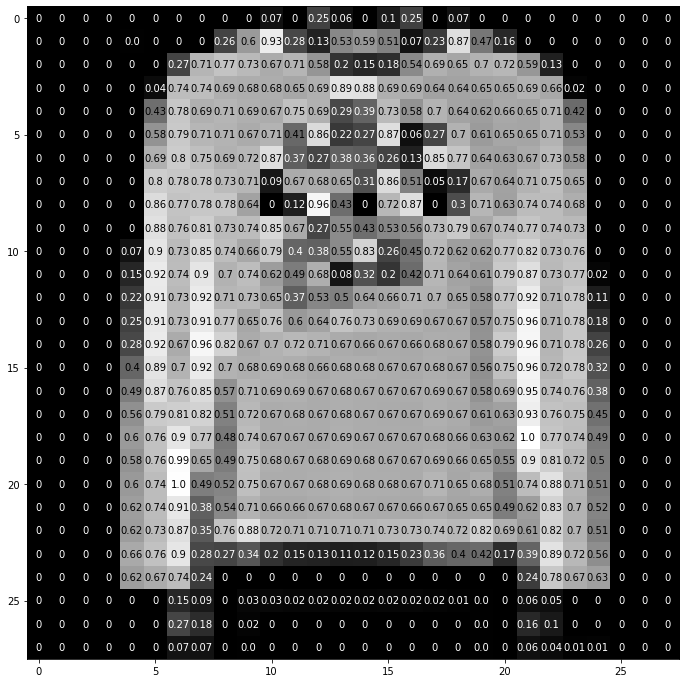

In [5]:
# select an image by index
idx = 2
img = np.squeeze(images[idx])

# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

What we have done till now is loaded and visualized the dataset. We have an analyzed, how an image looks like on the gray scale level. But there are other aspects of the network like loss function, optimization function, dropout etc.

To train a model, you'll need to define how it trains by selecting a loss function and optimizer. These functions decide how the model updates its parameters as it trains and can affect how quickly the model converges, as well.

Loss Functions : https://pytorch.org/docs/master/nn.html#loss-functions

Optimizer : http://pytorch.org/docs/master/optim.html

### Training the Network
Typically, we train any network for a number of epochs or cycles through the training dataset

Here are the steps that a training function performs as it iterates over the training dataset:

    * Prepares all input images and label data for training
    * Passes the input through the network (forward pass)
    * Computes the loss (how far is the predicted classes are from the correct labels)
    * Propagates gradients back into the network’s parameters (backward pass)
    * Updates the weights (parameter update)
    * It repeats this process until the average loss has sufficiently decreased.
    
https://github.com/udacity/CVND_Exercises/tree/master/1_5_CNN_Layers

In [128]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        ## output size = (W-F)/S +1 = (28-3)/1 +1 = 26
        # the output Tensor for one image, will have the dimensions: (10, 26, 26)
        # after one pool layer, this becomes (10, 13, 13)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # pool with kernel_size=2, stride=2
        self.pool = nn.MaxPool2d(2, 2)
        # second conv layer: 10 inputs, 20 outputs, 3x3 conv
        ## output size = (W-F)/S +1 = (13-3)/1 +1 = 11
        # the output tensor will have dimensions: (20, 11, 11)
        # after another pool layer this becomes (20, 5, 5); 5.5 is rounded down
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20*5*5, 50)
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        # finally, create 10 output channels (for the 10 classes)
        self.fc2 = nn.Linear(50, 10)
        
        
    # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        # prep for linear layer
        # this line of code is the equivalent of Flatten in Keras
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        
        x = F.relu(self.fc1(x))
        
        x = self.fc1_drop(x)

        x = self.fc2(x)
        # final output
        return x

# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [129]:
import torch.optim as optim

## TODO: specify loss function (try categorical cross-entropy)
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

## TODO: specify optimizer 
#optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [130]:
# # Calculate accuracy before training
# correct = 0
# total = 0

# # Iterate through test dataset
# for images, labels in test_loader:

#     # forward pass to get outputs
#     # the outputs are a series of class scores
#     outputs = net(images)

#     # get the predicted class from the maximum value in the output-list of class scores
#     _, predicted = torch.max(outputs.data, 1)

#     # count up total number of correct labels
#     # for which the predicted and true labels are equal
#     total += labels.size(0)
#     correct += (predicted == labels).sum()

# # calculate the accuracy
# # to convert `correct` from a Tensor into a scalar, use .item()
# accuracy = 100.0 * correct.item() / total

# # print it out!
# print('Accuracy before training: ', accuracy)

Train the Network

Below, we've defined a train function that takes in a number of epochs to train for.
The number of epochs is how many times a network will cycle through the entire training dataset.
Inside the epoch loop, we loop over the training dataset in batches; recording the loss every 1000 batches.


Here are the steps that this training function performs as it iterates over the training dataset:

    * Zero's the gradients to prepare for a forward pass
    * Passes the input through the network (forward pass)
    * Computes the loss (how far is the predicted classes are from the correct labels)
    * Propagates gradients back into the network’s parameters (backward pass)
    * Updates the weights (parameter update)
    * Prints out the calculated loss

In [131]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [132]:
# define the number of epochs to train for
n_epochs = 30 # start small to see if your model works, initially

# call train and record the loss over time
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 2.1832635352611542
Epoch: 1, Batch: 2000, Avg. Loss: 1.0919257186353206
Epoch: 1, Batch: 3000, Avg. Loss: 0.8763172917068005
Epoch: 2, Batch: 1000, Avg. Loss: 0.7871847065091133
Epoch: 2, Batch: 2000, Avg. Loss: 0.7427529121190309
Epoch: 2, Batch: 3000, Avg. Loss: 0.6988560717552901
Epoch: 3, Batch: 1000, Avg. Loss: 0.6680903125554323
Epoch: 3, Batch: 2000, Avg. Loss: 0.623036376580596
Epoch: 3, Batch: 3000, Avg. Loss: 0.6079560324847698
Epoch: 4, Batch: 1000, Avg. Loss: 0.5824680318683386
Epoch: 4, Batch: 2000, Avg. Loss: 0.5785296660661697
Epoch: 4, Batch: 3000, Avg. Loss: 0.5702273683547974
Epoch: 5, Batch: 1000, Avg. Loss: 0.5437173568606377
Epoch: 5, Batch: 2000, Avg. Loss: 0.5446670056059957
Epoch: 5, Batch: 3000, Avg. Loss: 0.5308983266428113
Epoch: 6, Batch: 1000, Avg. Loss: 0.5224888764619827
Epoch: 6, Batch: 2000, Avg. Loss: 0.5139985231757164
Epoch: 6, Batch: 3000, Avg. Loss: 0.5070429965555668
Epoch: 7, Batch: 1000, Avg. Loss: 0.50004976029

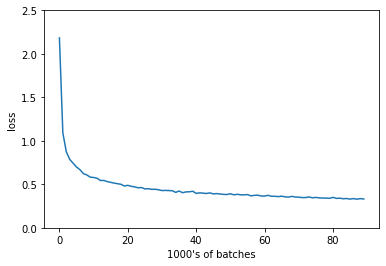

In [133]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

In [134]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.319594

Test Accuracy of T-shirt/top: 88% (887/1000)
Test Accuracy of Trouser: 97% (970/1000)
Test Accuracy of Pullover: 87% (873/1000)
Test Accuracy of Dress: 89% (890/1000)
Test Accuracy of  Coat: 78% (787/1000)
Test Accuracy of Sandal: 96% (966/1000)
Test Accuracy of Shirt: 58% (581/1000)
Test Accuracy of Sneaker: 95% (958/1000)
Test Accuracy of   Bag: 98% (981/1000)
Test Accuracy of Ankle boot: 95% (959/1000)

Test Accuracy (Overall): 88% (8852/10000)


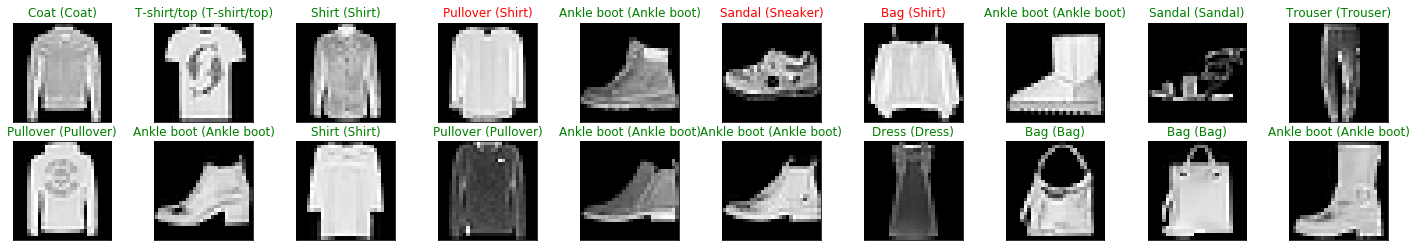

In [135]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Dropout and Momentum

We can see from above test results of each class that the model has performed poorly on coat and shirt. It seems to overfit the data.

### Dropout

Dropout randomly turns off perceptrons (nodes) that make up the layers of our network, with some specified probability. It may seem counterintuitive to throw away a connection in our network, but as a network trains, some nodes can dominate others or end up making large mistakes, and dropout gives us a way to balance our network so that every node works equally towards the same goal, and if one makes a mistake, it won't dominate the behavior of our model. You can think of dropout as a technique that makes a network resilient; it makes all the nodes work well as a team by making sure no node is too weak or too strong.

### Momentum
When you train a network, you specify an optimizer that aims to reduce the errors that your network makes during training. The errors that it makes should generally reduce over time but there may be some bumps along the way. Gradient descent optimization relies on finding a local minimum for an error, but it has trouble finding the global minimum which is the lowest an error can get. So, we add a momentum term to help us find and then move on from local minimums and find the global minimum!

Understanding the AlexNet: https://medium.com/@smallfishbigsea/a-walk-through-of-alexnet-6cbd137a5637

Batch Normalization: https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

## Notes from Udacity:

Preventing Overfitting:

Often we see batch norm applied after early layers in the network, say after a set of conv/pool/activation steps since this normalization step is fairly quick and reduces the amount by which hidden weight values shift around. Dropout layers often come near the end of the network; placing them in between fully-connected layers for example can prevent any node in those layers from overly-dominating.

Convolutional and Pooling Layers:

As far as conv/pool structure, I would again recommend looking at existing architectures, since many people have already done the work of throwing things together and seeing what works. In general, more layers = you can see more complex structures, but you should always consider the size and complexity of your training data (many layers may not be necessary for a simple task).

As You Learn

When you are first learning about CNN's for classification or any other task, you can improve your intuition about model design by approaching a simple task (such as clothing classification) and quickly trying out new approaches. You are encouraged to:

    * Change the number of convolutional layers and see what happens
    * Increase the size of convolutional kernels for larger images
    * Change loss/optimization functions to see how your model responds (especially change your hyperparameters such as learning rate and see what happens -- you will learn more about hyperparameters in the second module of this course)
    * Add layers to prevent overfitting
    * Change the batch_size of your data loader to see how larger batch sizes can affect your training

Always watch how much and how quickly your model loss decreases, and learn from improvements as well as mistakes!



In [136]:
torch.save(net.state_dict(),"/Users/mayurjain/Desktop/cnn_fashion.pt")